First, prepare the data about existing solar sites by cleaning column names, dropping unnecessary columns, calculating the distance to transmission lines, and calculating the slope and aspect of .

    Select only sites in the USA and drop all geometries that represent single points.

In [41]:
import math

import geopandas
import geopandas as gpd
from pathlib import Path

import numpy as np

solarSource = gpd.read_file(str(Path("../data/global_solar_2020.gpkg")))

In [42]:
solarSource = solarSource[solarSource.GID_0 == "USA"]
solarSource.loc[:, "geometry"] = solarSource[(solarSource.geom_type!="MultiPoint") & (solarSource.geom_type!="Point")]
solarSource = solarSource.loc[solarSource.is_valid]

solarSource.geom_type

10525    MultiPolygon
10526    MultiPolygon
10527    MultiPolygon
10528    MultiPolygon
10529    MultiPolygon
             ...     
34232         Polygon
34233         Polygon
34234         Polygon
34235         Polygon
34237         Polygon
Length: 3381, dtype: object

        Convert from square kilometers to acres.

In [43]:
# 1 square kilometer per 247.10538161 acres
kToAcre = 247.10538161
solarSource.rename(columns={"landscape.area":"acres"}, inplace=True)
solarSource = solarSource.drop(columns=["GID_0", "urban", "panels", "water", "power"])

In [44]:
solarSource.rename(columns={"panel.area":"panelacres"}, inplace=True)
solarSource["acres"] = round(solarSource.acres*kToAcre)
solarSource["panelacres"] = round(solarSource.panelacres*kToAcre)

        There are some sites that multi-polygons that are either individual panel clusters or panel rows.  This will throw the
    data off when trying to compute site size (Austin, Texas, for example, shows a very large solar site, but it is really
    just roof panels on individual domiciles).  Next, the individual polygons will each be buffered by 300m
    (i.e. two polygons 600m apart will touch).

In [45]:
exploded = solarSource.copy()
exploded=exploded.explode()
explodedBuffer = exploded.copy()
explodedBuffer["geometry"] = exploded.buffer(300)

In [46]:
merged = gpd.GeoDataFrame(explodedBuffer.unary_union)

In [47]:
merged = merged.reset_index().rename(columns={0: "geometry"})
merged = merged.set_geometry("geometry")
merged.reset_index(inplace=True)
merged["id"] = merged.index
merged["newPoly"] = merged.index
merged.crs = exploded.crs

In [48]:
reshaped = gpd.sjoin(exploded, merged, how="inner", op="intersects")

In [49]:
reshaped = reshaped.dissolve(by="newPoly")

In [50]:
reshaped["panelacres"] = reshaped.geometry.area * 0.0002471052
reshaped["geometry"] = reshaped.convex_hull
reshaped["siteacres"] = reshaped.geometry.area * 0.0002471052

In [53]:
toDrop = list()
for index, row in reshaped.iterrows():
    if (row["panelacres"] / row["siteacres"]) < 0.1:
        toDrop.append(int(index))

reshaped.drop(index=toDrop, inplace=True)
reshaped.drop(columns=["index_right", "index", "level_0"], inplace=True)

        For the moment, the aspect and slope of the existing solar sites is calculated using QGIS and the 3DEP WCS
    (https://elevation.nationalmap.gov/arcgis/rest/services/3DEPElevation/ImageServer) and read in to this program.  Because of the large number of
    different geographic locations, downloading the elevation raster zone for each site is not feasible.
    It should be possible to use the slopeAspect module in the near future by fetching each site location from the USGS service
    as an affined array.

In [54]:
siteStats = gpd.read_file(str(Path("../data/existingSlopeAspect.gpkg")))
substations = gpd.read_file(str(Path("../data/Electric_Substations-shp.zip")))
transLines = gpd.read_file(str(Path("../data/Electric_Power_Transmission_Lines-shp.zip")))
transLines = transLines.to_crs(solarSource.crs)
substations = substations.to_crs(solarSource.crs)


In [55]:
siteStats.drop(columns=["geometry"], inplace=True)
siteStats.rename(columns={"aspect_mean":"aspect", "slope_mean":"slope"}, inplace=True)
reshaped = reshaped.merge(siteStats, on="id")

In [ ]:
reshapedBuffer = gpd.GeoDataFrame()
reshapedBuffer["geometry"] = reshaped.geometry.copy()
reshapedBuffer.geometry = reshapedBuffer.buffer(40000)
reshapedBuffer.crs = reshaped.crs

In [56]:
substationsClipped = gpd.clip(substations, reshapedBuffer)
substationsClipped.to_crs(solarSource.crs, inplace=True)
linesClipped = gpd.clip(transLines, reshapedBuffer)
linesClipped.to_crs(solarSource.crs, inplace=True)

        Calculating the shortest distance to transmission lines and substations takes approximately 10 minutes.

In [ ]:
from geoutilities import slopeAspect
from importlib import reload
reload(slopeAspect)
reshaped["line_m"] = slopeAspect.distanceparallel(reshaped, linesClipped, "line_m")

In [ ]:
reshaped["substation_m"] = slopeAspect.distanceparallel(reshaped, substationsClipped, "substation_m")


        Convert the slope from degrees to percent

In [ ]:
reshaped.loc[:,"slope"] = reshaped.slope.apply(lambda d: math.tan(math.radians(d)) * 100)
reshaped.to_crs(epsg=4236, inplace=True)

In [ ]:
solarSites = reshaped.copy()

        Choose the lower distance from substation_m and line_m as toGrid

In [ ]:
for index, row in solarSites.iterrows():
    if row["substation_m"] >= row["line_m"]:
        solarSites.loc[index, "toGrid"] = row["line_m"]
    else:
        solarSites.loc[index, "toGrid"] = row["substation_m"]

        First, average the site acres and panel acres. Then, assign a size small, medium, or large to the solar sites depending on the acreage

In [ ]:
solarSites["acres"] = (solarSites.siteacres + solarSites.panelacres) / 2

def smMdLrg(acres):
    if acres < 1:
        return "small"
    elif 1 <= acres < 100:
        return "medium"
    else:
        return  "large"

solarSites.loc[:,"size"] = solarSites.loc[:,"acres"].apply(smMdLrg)

        Set the urban column using the US Census standards

In [ ]:
import geopandas as gpd
from pathlib import Path

urbanAreas = gpd.read_file(Path("../data/tl_2020_us_uac10.zip"))
urbanAreas = urbanAreas.to_crs(solarSites.crs)

# Find the sites that intersect an urban area
isUrban = gpd.sjoin(urbanAreas, solarSites, how="inner", op="intersects")
urbanlist = isUrban["index_right"].to_list()


for sites in urbanlist:
    solarSites.at[sites, "definition"] = "urban"

solarSites.loc[(solarSites.definition != "urban"), "definition"] = "rural"

In [ ]:
solarSites.to_file(str(Path("../data/trainingSites2.gpkg")), driver="GPKG")

        Now, we will use k-means clustering to analyze the prepared solar site data

In [ ]:
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path
import geopandas as gpd
import pandas as pd

originalSolarData = gpd.read_file(str(Path("../data/trainingSites.gpkg")))
originalSolarData = pd.get_dummies(originalSolarData, columns=["definition"])

solarDataSet = originalSolarData.loc[((originalSolarData.toGrid < 2000) & (originalSolarData.acres > 5)),
                                     ["toGrid", "slope", "aspect", "definition_urban", "definition_rural", "acres"]].copy()

inertia = list()
scaler = StandardScaler().fit(solarDataSet)
scaledData = scaler.transform(solarDataSet)
pca = PCA(n_components=0.99)
dataTransform = pca.fit_transform(scaledData)
for k in range(2, 10):
    clusterModel = KMeans(n_clusters=k).fit(dataTransform)
    inertia.append(clusterModel.inertia_)

elbow = pd.DataFrame([range(2,10), inertia]).transpose()
elbow.columns = ["k-val", "inertia"]
elbow.plot(x="k-val", y="inertia")


In [ ]:
clusterModel = KMeans(n_clusters=4).fit(dataTransform)
solarDataSet.loc[:, "group"] = clusterModel.predict(dataTransform)

label = clusterModel.predict(dataTransform)
print(solarDataSet["group"].value_counts())
print(clusterModel.inertia_)

In [ ]:
solarDataSet.corr()

In [ ]:
import numpy
unique = numpy.unique(label)
centroids = clusterModel.cluster_centers_

# plotting the results:
for i in unique:
    pyplot.scatter(dataTransform[label==i, 0], dataTransform[label==i, 1], label=i)

pyplot.scatter(centroids[:,0], centroids[:,1], s=80, color='c')
pyplot.legend()
pyplot.figure(figsize=(15,15)).show()

In [ ]:
mn = solarDataSet.group.min()
mx = solarDataSet.group.max()
for x in range(mn, (mx+1)):
    print(f"Group {x} MEDIAN")
    print(solarDataSet[solarDataSet["group"] == x].median())
    print(f"Group {x} MEAN")
    print(solarDataSet[solarDataSet["group"] == x].mean())
    print("\n")

        Filter outlier groups

In [ ]:
val_counts = solarDataSet["group"].value_counts().to_frame().copy()
overFive = int(solarDataSet.count()[0] * 0.05)

In [ ]:
top = list()
for index, groupID in val_counts.iterrows():
    print(groupID.values)
    if groupID["group"] > overFive:
        top.append(groupID.name)

topgroups = solarDataSet[solarDataSet["group"].isin(top)]

        Plot the top groups

In [ ]:
import seaborn as sns
sns.displot(topgroups, x="toGrid", y="acres", bins=15)

In [ ]:
topgroups.to_csv("../data/topgroups.csv")

Create a Random Forest Classification model

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report

toAnalyze = pd.read_csv(Path("../data/topgroups.csv"))
toAnalyze["solarsite"] = 1

In [2]:
X = toAnalyze.loc[:, ["toGrid", "aspect", "slope", "acres"]].copy()
y = toAnalyze.loc[:, ["solarsite"]].copy()
scale = StandardScaler().fit(X)

        The remaining number of solar sites to go off after the data were filtered turned out to be rather few, so we will
    generate synthetic data and try to (against correct practice) scale it based on the gathered data.

In [24]:
X_gen,y_gen = make_classification(n_samples=100000, n_features=4, n_informative=4, n_redundant=0, n_repeated=0,
                                  n_classes=2, n_clusters_per_class=2, class_sep=1.5, weights=[0.7, 0.3])

In [4]:
X_gen = pd.DataFrame(X_gen)
X_gen = scale.inverse_transform(X_gen.abs())

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_gen, y_gen, test_size=0.3, random_state=2021)

In [16]:
RFC_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = RFC_model.predict(X_test)

        The model appears successfully eliminate non-solar sites but will need further investigaton to improve the false-negatives (nonsolar
    that should be considered potential sites).

0.97383


,Importance
toGrid,0.232206
acres,0.236748
slope,0.264565
aspect,0.266480


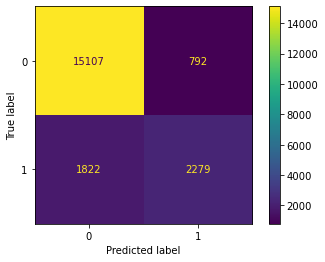

<Figure size 6000x6000 with 0 Axes>

In [17]:
import matplotlib.pyplot as pyplot

print(RFC_model.score(X_gen, y_gen))
plot_confusion_matrix(RFC_model, X_test, y_test)
pyplot.figure(figsize=(20,20), dpi=300)

pd.DataFrame([RFC_model.feature_importances_], columns=X.columns, index=["Importance"]).transpose().sort_values("Importance")

    Export the model

Finally, assess the accuracy with real world data using 9 counties from across the state using known
requirements for a solar site.  You may have to repeat the above process to get a sufficient model.

In [8]:
import geopandas
from pathlib import Path
from sqlalchemy import create_engine

db = "postgresql://doadmin:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
con = create_engine(db)
countyQuery = "SELECT acres, to_grid, slope, aspect, geometry FROM {}"

sampledCountiesList = ["geauga_parcels", "harrison_parcels", "washington_parcels", "huron_parcels", "licking_parcels",
                   "lawrence_parcels", "fulton_parcels", "auglaize_parcels", "clermont_parcels"]

sampledCountiesgdf = geopandas.GeoDataFrame()

for county in sampledCountiesList:
    sampledCountiesgdf = sampledCountiesgdf.append(geopandas.read_postgis(countyQuery.format(county), con, geom_col="geometry"))

In [ ]:
from pickle import load
treemodel: RandomForestClassifier
pkldModel = Path("../models/tree_model.pkl")
with open(pkldModel, "rb") as pklfile:
    treemodel = load(pklfile)


In [18]:
from pandas import DataFrame

prediction = treemodel.predict(sampledCountiesgdf[["to_grid", "aspect", "slope", "acres"]])
analyzedData = DataFrame(prediction)
sampledCountiesgdf["solarsites"] = analyzedData.values

In [19]:
standard = sampledCountiesgdf[(sampledCountiesgdf.to_grid < 1600) &
                              (sampledCountiesgdf.slope < 10)
                              ]


selected = sampledCountiesgdf[sampledCountiesgdf.solarsites == 1]

In [20]:
print(f"The stats for the standard: \n  Slope Mean:{sampledCountiesgdf.slope.mean()} \n Slope Median {sampledCountiesgdf.slope.median()} \n"
      f" to_grid Mean:{sampledCountiesgdf.to_grid.mean()} \n Slope Median {sampledCountiesgdf.slope.median()} \n"
      f"Slope Mean:{sampledCountiesgdf.slope.mean()} \n Slope Median {sampledCountiesgdf.slope.median()} \n")

The stats for the standard: 
  Slope Mean:5.975076710869652 
 Slope Median 2.96994209289551 
 to_grid Mean:1906.3018605038683 
 Slope Median 2.96994209289551 
Slope Mean:5.975076710869652 
 Slope Median 2.96994209289551 



In [21]:
print(f"The mean values for the standard are: \n {standard.mean()}\n")
print(f"The median values for the standard are: \n {standard.median()} \n\n")
print(f"The mean values for the model's selected are: \n {selected.mean()}\n")
print(f"The median values for the model's selection are: \n {selected.median()}")

The mean values for the standard are: 
 acres           3.872016
to_grid       717.236564
slope           2.954948
aspect        182.539714
solarsites      0.099241
dtype: float64

The median values for the standard are: 
 acres           0.460000
to_grid       692.618724
slope           2.099423
aspect        182.029076
solarsites      0.000000
dtype: float64 


The mean values for the model's selected are: 
 acres            6.207709
to_grid       1394.643261
slope            9.918662
aspect         234.431425
solarsites       1.000000
dtype: float64

The median values for the model's selection are: 
 acres            0.640000
to_grid       1442.437550
slope            9.617124
aspect         232.268914
solarsites       1.000000
dtype: float64


In [22]:
# Percent of how many of the parcels the model selected out of the total number that fit the standard
round(len(standard[standard.solarsites == 1])/len(standard) * 100, 1)

# Percent of the model's selected parcels that fit the standard

round(len(standard[standard.solarsites == 1]) / len(selected) * 100, 1)

The model on picked 48.5% of the sampled parcels that fit the standard, however 74.8% of the selected parcels
did in fact fit the standard.
